In [2]:
# This is a temporaly line to run that adds the modules to the pythopath
import sys
sys.path.append('/home/azureuser/cloudfiles/code/Users/admin/Paychex_revenue_forecast')

In [4]:
import numpy as np
import pandas as pd
from io import BytesIO
#from azure.storage.blob import BlobServiceClient
from src.paychex_ml.utils import load_credentials
import matplotlib.pyplot as plt

In [5]:
credentials = load_credentials("blob_storage",
                               file="/home/azureuser/cloudfiles/code/Users/admin/Paychex_revenue_forecast/credentials.yml")

In [6]:
# Start client
container_name = "clean-data"
blob_service_client = BlobServiceClient.from_connection_string(credentials['conn_string'])
container_client = blob_service_client.get_container_client(container_name)

# Download file
file = 'table_predictable.csv'
stream_downloader = container_client.download_blob(file)
with BytesIO() as stream:
    stream_downloader.readinto(stream)
    stream.seek(0)
    df = pd.read_csv(stream, dtype={'Period':str, 'Calendar Date': str})

In [7]:
items = ['401K Asset fee & BP Revenue',
         '401K Fee Revenue',
         'ASO Allocation',
         'ASO Revenue - Oasis',
         'Benetrac',
         'Cafeteria Plans Revenue',
         'Delivery Revenue',
         'Emerging Products',
         'ESR Revenue',
         'Full Service Unemployment Revenue',
         'Health Benefits',
         'HR Online',
         'HR Solutions (PEO)',
         'Interest on Funds Held for Clients',
         'Other Processing Revenue',
         'Payroll blended products',
         'SurePayroll.',
         'Time & Attendance',
         'Total international',
         'Total Paychex Advance',
         'Total PEO',
         'W-2 Revenue',
         'Workers Comp - Payment Services'
         ]

In [8]:
df = df[(df['Scenario']=='Actual')&(df['Item'].isin(items))]\
    .groupby(['Calendar Date', 'Item']).sum()\
    .unstack(level=1)['Value']

In [9]:
df.head()

Item,401K Asset fee & BP Revenue,401K Fee Revenue,ASO Allocation,ASO Revenue - Oasis,Benetrac,Cafeteria Plans Revenue,Delivery Revenue,ESR Revenue,Emerging Products,Full Service Unemployment Revenue,...,Interest on Funds Held for Clients,Other Processing Revenue,Payroll blended products,SurePayroll.,Time & Attendance,Total PEO,Total Paychex Advance,Total international,W-2 Revenue,Workers Comp - Payment Services
Calendar Date,,,,,,,,,,,,,,,,,,,,,
20140601,4261452.0,10621963.0,7255027.55,0.0,1922941.0,1714950.0,7393351.97,47602.0,796063.0,1869396.0,...,3308154.0,4765775.19,99633512.0,3246967.02,4651817.0,12948696.0,0.0,808003.64,7031234.09,4858397.0
20140701,4513388.0,10558382.0,9070820.80,0.0,1916579.0,1698495.0,13513741.18,67521.0,986955.0,2341533.0,...,3466375.0,6502729.54,121619696.0,3362473.02,5165885.0,14670286.0,0.0,855305.18,7325377.82,5244318.0
20140801,4486436.0,10297495.0,7489159.50,0.0,1944830.0,1829118.0,7286966.62,79771.0,924689.0,1986835.0,...,3434419.0,4215268.17,99472483.0,3286111.93,4856677.0,14606689.0,0.0,801651.38,7443620.46,5588578.0
20140901,4355891.0,12719409.0,7011292.24,0.0,1933042.0,1710602.0,7081861.96,105330.0,732444.0,1888067.0,...,3419918.0,4726806.24,94198230.0,3345328.53,5098280.0,14456325.0,0.0,834334.16,7414842.11,4968759.0
20141001,4455231.0,13797724.0,9372927.59,0.0,1956820.0,1702224.0,13741077.44,143956.0,1051920.0,2491011.0,...,3472038.0,6514037.07,124353873.0,3402641.78,5188982.0,14544813.0,0.0,869205.85,7818212.35,5752070.0


In [11]:
df_external = pd.read_feather("ext_var_sel.feather").set_index('date')

In [214]:
# Start client
container_name = "clean-data"
blob_service_client = BlobServiceClient.from_connection_string(credentials['conn_string'])
container_client = blob_service_client.get_container_client(container_name)

# Download file
file = 'table_drivers.csv'
stream_downloader = container_client.download_blob(file)
with BytesIO() as stream:
    stream_downloader.readinto(stream)
    stream.seek(0)
    df_drivers = pd.read_csv(stream, dtype={'Period':str, 'Calendar Date': str})

In [34]:
df_drivers = pd.read_csv("C:/Users/bruno.gonzalez/DataspellProjects/Paychex_revenue_forecast/data/clean/table_drivers.csv")

In [35]:
df_drivers = df_drivers[df_drivers['Scenario']=='Actual']

In [36]:
df_drivers['driver'] = df_drivers['Product']+ df_drivers['Account']+ df_drivers['Detail']

# Models

In [68]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor

In [135]:
def mean_absolute_percentage_error(actual, forecast):
    return (actual-forecast).abs().divide(actual.abs()).mean()

In [383]:
def create_X(item_name, df, df_external=None, driver_name='', df_drivers=None, ohe_months=True):
    
    df_item = df[item_name]
    
    if df_drivers is None:
        df_drivers = pd.DataFrame()
        
    else:
        df_drivers = df_drivers[df_drivers['Item']==driver_name][['Calendar Date', 'driver','Value']]\
        .set_index(['Calendar Date', 'driver']) \
        .unstack(1) \
        ['Value'] \
        .dropna(axis=1)
    
    df_external = pd.DataFrame() if df_external is None else df_external
    
    X = pd.concat([df_item.shift(12).rename("t-12"),
               df_external,
               df_drivers.dropna(axis=1)],
              axis=1)\
    .dropna()
    y = df_item.filter(items = X.index)
    
    X = X.reset_index()
    X['year'] = X['index'].str[:4]
    X['month'] = X['index'].str[4:6]
    X = X.drop(columns=['index'])
    if ohe_months:
        X = pd.get_dummies(X, columns=['month'])
   
    return X, y

In [372]:
def model_train_featue_selection(model, X, y):

    
    train_size = round(len(X)*0.84)
    X_train = X.iloc[:train_size,:]
    y_train = y.iloc[:train_size]
    X_test = X.iloc[train_size:,:]
    y_test = y.iloc[train_size:]
    
    tscv = TimeSeriesSplit(n_splits=4)
    
    X_train_it = X_train.copy()
    X_test_it = X_test.copy()
    var_droped = []
    mape_list = [1, 1]
    gs_gb = model
    while mape_list[-1]*0.9 <= mape_list[-2]:
    #for i in range(n_iter):
        best_model = gs_gb
        gs_gb = GridSearchCV(model, parameters, n_jobs=-1, verbose=1, cv=tscv)
        gs_gb.fit(X_train_it, y_train)
        coef = pd.DataFrame(gs_gb.best_estimator_.feature_importances_,
                            index = X_train_it.columns,
                            columns=['coefficient'])
        v = coef.abs().sort_values(['coefficient']).index[0]

        y_pred_gsgb = gs_gb.predict(X_test_it)

        mae = mean_absolute_error(y_test, y_pred_gsgb)
        mape = mean_absolute_percentage_error(y_test, y_pred_gsgb)
        print("Mean absolute error: ", mae)
        print("Mean absolute percentage error: ", round(mape*100,2))
        mape_list.append(mape)

        fig, ax = plt.subplots(figsize=(12,4))

        ax.plot(y_train, label='training')
        ax.plot(y_test, label='testing')
        ax.plot(pd.DataFrame(y_pred_gsgb).set_index(y_test.index), label='prediction', ls="--")
        # Define the date format
        plt.xticks(rotation = 90)
        plt.legend()
        plt.show()

        X_train_it = X_train_it.drop(v, axis=1)
        X_test_it = X_test_it.drop(v, axis=1)
        var_droped.append(v)
        
    return best_model, var_droped[:-1], mape_list[2:]

## Lasso

In [8]:
item_name = 'Payroll blended products'
driver_name = 'Payroll blended products Drivers'
df_item = df[item_name]

NameError: name 'df' is not defined

In [30]:
df_drivers

,Calendar Date,Scenario,Version,Fiscal Year,Period,File,Product,Account,Detail,Item,Value,driver
0,20140601,Actual,Final Revised,FY15,1,401kRevenueDetail.txt,401(K) PLANS,5765 SEBS,Sales - RW,401kRevenue Drivers,6.0,401(K) PLANS5765 SEBSSales - RW
1,20140601,Actual,Final Revised,FY15,1,401kRevenueDetail.txt,401(k) PEP,5600 401K ADMINISTRATION,Sales - RW,401kRevenue Drivers,NaN,401(k) PEP5600 401K ADMINISTRATIONSales - RW
2,20140601,Actual,Final Revised,FY15,1,401kRevenueDetail.txt,PRD349ASO,5600 401K ADMINISTRATION,Sales - RW,401kRevenue Drivers,NaN,PRD349ASO5600 401K ADMINISTRATIONSales - RW
3,20140601,Actual,Final Revised,FY15,1,401kRevenueDetail.txt,PRD349PEO,5600 401K ADMINISTRATION,Sales - RW,401kRevenue Drivers,NaN,PRD349PEO5600 401K ADMINISTRATIONSales - RW
4,20140601,Actual,Final Revised,FY15,1,401kRevenueDetail.txt,401(K) PLANS,5600 401K ADMINISTRATION,Sales - RW,401kRevenue Drivers,826.0,401(K) PLANS5600 401K ADMINISTRATIONSales - RW
...,...,...,...,...,...,...,...,...,...,...,...,...
207559,20210501,Actual,Final Revised,FY21,12,SurePayollRevenueDrivers.txt,AMENDED RETURN PROCESSING,1517 SP MT BANK,Revenue / Billable PR,SurePayroll. Drivers,1.0,AMENDED RETURN PROCESSING1517 SP MT BANKRevenu...
207560,20210501,Actual,Final Revised,FY21,12,SurePayollRevenueDrivers.txt,SP EIN REVENUE,1517 SP MT BANK,Revenue / Billable PR,SurePayroll. Drivers,NaN,SP EIN REVENUE1517 SP MT BANKRevenue / Billabl...
207561,20210501,Actual,Final Revised,FY21,12,SurePayollRevenueDrivers.txt,SP EE SCREENING,1517 SP MT BANK,Revenue / Billable PR,SurePayroll. Drivers,0.0,SP EE SCREENING1517 SP MT BANKRevenue / Billab...
207562,20210501,Actual,Final Revised,FY21,12,SurePayollRevenueDrivers.txt,SP SUBSCRIPTION,1517 SP MT BANK,Revenue / Billable PR,SurePayroll. Drivers,72.0,SP SUBSCRIPTION1517 SP MT BANKRevenue / Billab...


In [33]:
df_drivers.drop_duplicates()

Value
Calendar Date driver                                                      
20140601      Total Flex Blended Products RevenueAuburn RSCSa...     657.0
              Total Flex Blended Products RevenueRochester RS...     557.0
              Total Flex Blended Products RevenueGreensboro R...     397.0
              Total Flex Blended Products RevenueLehigh Valle...    1007.0
              Total Flex Blended Products RevenueMiddletown R...     236.0
...                                                                    ...
20210501      Total Advantage Blended Products RevenueADVANTA...   11275.0
              Total Advantage Blended Products RevenueADVANTA...  268867.0
              Total Advantage Blended Products RevenueADVANTA...   11395.0
              Total Advantage Blended Products RevenueADVANTA...   12964.0
              Total Advantage Blended Products RevenueADVANTA...   11673.0

[13568 rows x 1 columns]

In [37]:
df_drivers = df_drivers[df_drivers['Item']==driver_name][['Calendar Date', 'driver','Value']]\
    .drop_duplicates() \
    .set_index(['Calendar Date', 'driver']) \
    .unstack(1)\
    ['Value']

In [39]:
df_drivers

driver,Product NA6000 CORP OFFICE# of Weeks - RW,Total Advantage Blended Products Revenue0920 DSC EastNon Processing Clients,Total Advantage Blended Products Revenue0921 DSC WestNon Processing Clients,Total Advantage Blended Products Revenue0922 DSC CentralNon Processing Clients,Total Advantage Blended Products Revenue0923 Dedicated Service Center 2Non Processing Clients,Total Advantage Blended Products RevenueADVANTAGE/PACEAdmin Fee Discount - RW,Total Advantage Blended Products RevenueADVANTAGE/PACEAverage Check per Client - RW,Total Advantage Blended Products RevenueADVANTAGE/PACEAverage Check per Payroll - RW,Total Advantage Blended Products RevenueADVANTAGE/PACEAverage Client Base - RW,Total Advantage Blended Products RevenueADVANTAGE/PACEAverage Client Base QTD - RW,...,Total Preview Blended Products Revenue0499 PREVIEW SERVICE CENTERSales - RW,Total Preview Blended Products Revenue0499 PREVIEW SERVICE CENTERTransfers in - RW,Total Preview Blended Products Revenue0499 PREVIEW SERVICE CENTERTransfers out - RW,Total Preview Blended Products Revenue0499 PREVIEW SERVICE CENTERWeighted Average Payroll Frequency - RW,Total Preview Blended Products Revenue0940 MULTI PRODUCT SERVICE CENTER ROCHESTERNon Processing Clients,Total Preview Blended Products Revenue0942 MULTI PRODUCT SERVICE CENTER PHOENIXNon Processing Clients,Total Preview Blended Products Revenue0943 MULTI PRODUCT SERVICE CENTER INDYNon Processing Clients,Total Preview Blended Products Revenue0944 MULTI PRODUCT SERVICE CENTER NASHVILLENon Processing Clients,Total Preview Blended Products RevenueNashville RSCAverage annual payroll frequency - RW,Total Preview Blended Products RevenueSarasota/SmallBizNon Processing Clients
Calendar Date,,,,,,,,,,,,,,,,,,,,,
20140601,4.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,17409.0,17409.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20140701,5.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,17300.0,17350.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20140801,4.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,17181.0,17295.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20140901,4.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,17081.0,17081.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20141001,5.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,16985.0,17033.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20210101,5.0,NaN,NaN,NaN,NaN,-10.0,9.0,6.0,12648.0,12829.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210201,4.0,NaN,NaN,NaN,NaN,-10.0,9.0,6.0,12261.0,12657.0,...,NaN,NaN,NaN,NaN,870.0,381.0,275.0,217.0,NaN,NaN
20210301,5.0,NaN,NaN,NaN,NaN,-10.0,9.0,6.0,11952.0,11952.0,...,NaN,NaN,NaN,NaN,751.0,298.0,260.0,173.0,NaN,NaN


In [47]:
df_drivers.dropna(axis=1)

driver,401(K) PLANS5010 NATIONAL SALESSales - RW,401(K) PLANS5020 EPlan SalesSales - RW,401(K) PLANS5600 401K ADMINISTRATIONAverage Asset Values - Calculated - RW,401(K) PLANS5600 401K ADMINISTRATIONAverage Assets/Clients - Calculated - RW,401(K) PLANS5600 401K ADMINISTRATIONBasis Pts - Calc - RW,401(K) PLANS5600 401K ADMINISTRATIONEnding Asset Values - RW,401(K) PLANS5600 401K ADMINISTRATIONEnding Client Base - RW,401(K) PLANS5600 401K ADMINISTRATIONLoss % of BCB,401(K) PLANS5600 401K ADMINISTRATIONLosses - RW,401(K) PLANS5600 401K ADMINISTRATIONMaintenance Rate - Calculated - RW,...,PRD351ASO5600 401K ADMINISTRATIONLosses - RW,PRD351ASO5600 401K ADMINISTRATIONSales - RW,PRD351PEO5600 401K ADMINISTRATIONEnding Client Base - RW,PRD351PEO5600 401K ADMINISTRATIONLoss % of BCB,PRD351PEO5600 401K ADMINISTRATIONLosses - RW,PRD351PEO5600 401K ADMINISTRATIONSales - RW,PRD351RRS5600 401K ADMINISTRATIONEnding Client Base - RW,PRD351RRS5600 401K ADMINISTRATIONLoss % of BCB,PRD351RRS5600 401K ADMINISTRATIONLosses - RW,RETIREMENT PLANS5010 NATIONAL SALESSales - RW
Calendar Date,,,,,,,,,,,,,,,,,,,,,
20140601,809.0,13.0,3.179373e+10,680691.0,0.0,2.051014e+10,46708.0,-1.0,-479.0,190.0,...,-39.0,272.0,2207.0,0.0,-3.0,45.0,727.0,-1.0,-10.0,66.0
20140701,1008.0,7.0,2.036296e+10,436543.0,0.0,2.021578e+10,46646.0,-2.0,-741.0,187.0,...,-115.0,187.0,2191.0,-1.0,-23.0,31.0,737.0,-2.0,-12.0,67.0
20140801,1051.0,6.0,2.047145e+10,435822.0,0.0,2.072711e+10,46972.0,-1.0,-420.0,187.0,...,-59.0,231.0,2202.0,0.0,-10.0,28.0,753.0,-1.0,-10.0,72.0
20140901,1255.0,25.0,2.052380e+10,431880.0,0.0,2.032050e+10,47522.0,-1.0,-483.0,185.0,...,-66.0,268.0,2223.0,-1.0,-12.0,41.0,763.0,-1.0,-10.0,61.0
20141001,862.0,37.0,2.041411e+10,425826.0,0.0,2.050772e+10,47940.0,-1.0,-703.0,187.0,...,-89.0,261.0,2266.0,0.0,-11.0,49.0,784.0,-1.0,-10.0,102.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20210101,1421.0,69.0,3.962904e+10,623274.0,0.0,3.945419e+10,63582.0,-2.0,-967.0,201.0,...,-186.0,506.0,5681.0,-3.0,-140.0,255.0,464.0,-3.0,-14.0,148.0
20210201,1301.0,60.0,3.999195e+10,628399.0,0.0,4.052971e+10,63641.0,-1.0,-780.0,207.0,...,-104.0,199.0,5641.0,-2.0,-94.0,53.0,456.0,-2.0,-8.0,151.0
20210301,1425.0,59.0,4.089840e+10,644100.0,0.0,4.126708e+10,63497.0,-2.0,-957.0,203.0,...,-118.0,163.0,5612.0,-2.0,-103.0,75.0,443.0,-3.0,-13.0,192.0


In [48]:
X = pd.concat([df_item.shift(12).rename("t-12"),
               df_external,
               df_drivers.dropna(axis=1)],
              axis=1)\
    .dropna()

In [49]:
y = df_item.filter(items = X.index)
y

Calendar Date
20150601    10448029.0
20150701    11213386.0
20150801    10818192.0
20150901    11672780.0
20151001    10748772.0
               ...    
20210101    14541668.0
20210201    14785257.0
20210301    15017238.0
20210401    14843783.0
20210501    14198601.0
Name: 401K Fee Revenue, Length: 72, dtype: float64

In [50]:
X = X.reset_index()

In [51]:
X['year'] = X['index'].str[:4]
X['month'] = X['index'].str[4:6]

In [52]:
X = X.drop(columns=['index'])

In [53]:
X = pd.get_dummies(X, columns=['month'])

In [54]:
X

,t-12,PSAVERT,FYFR,FYONET,FYFSD,CIVPART,INDPRO,ALTSALES,DGORDER,CP,...,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12
0,10621963.0,7.4,3.192321e+06,3.645077e+06,-4.527563e+05,62.7,100.5063,17.401,235097.0,1751.129637,...,0,0,0,1,0,0,0,0,0,0
1,10558382.0,7.3,3.211093e+06,3.660329e+06,-4.492357e+05,62.6,101.1831,17.827,228622.0,1732.347000,...,0,0,0,0,1,0,0,0,0,0
2,10297495.0,7.3,3.230492e+06,3.676090e+06,-4.455979e+05,62.6,100.9115,17.940,224197.0,1699.645370,...,0,0,0,0,0,1,0,0,0,0
3,12719409.0,7.4,3.249890e+06,3.691850e+06,-4.419600e+05,62.4,100.5680,17.833,218491.0,1666.943739,...,0,0,0,0,0,0,1,0,0,0
4,13797724.0,7.5,3.251372e+06,3.705027e+06,-4.536559e+05,62.5,100.1588,17.818,222726.0,1635.297000,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,14914098.0,19.9,3.630385e+06,6.643464e+06,-3.013079e+06,61.4,99.4076,16.779,243160.0,2367.593000,...,0,0,0,0,0,0,0,0,0,0
68,14831603.0,13.5,3.683548e+06,6.666297e+06,-2.982750e+06,61.5,96.3966,15.932,246261.0,2478.777944,...,0,0,0,0,0,0,0,0,0,0
69,14754270.0,26.6,3.731566e+06,6.686921e+06,-2.955356e+06,61.5,99.1618,17.641,249467.0,2579.203056,...,1,0,0,0,0,0,0,0,0,0
70,14109521.0,12.6,3.784728e+06,6.709755e+06,-2.925026e+06,61.7,99.2416,18.297,247644.0,2690.388000,...,0,1,0,0,0,0,0,0,0,0


In [55]:
train_size = round(len(X)*0.84)

In [56]:
X_train = X.iloc[:train_size,:]
y_train = y.iloc[:train_size]

In [57]:
X_test = X.iloc[train_size:,:]
y_test = y.iloc[train_size:]

In [58]:
y_test

Calendar Date
20200601    13747697.0
20200701    14737454.0
20200801    14392679.0
20200901    16883067.0
20201001    14170117.0
20201101    14230746.0
20201201    14829062.0
20210101    14541668.0
20210201    14785257.0
20210301    15017238.0
20210401    14843783.0
20210501    14198601.0
Name: 401K Fee Revenue, dtype: float64

In [70]:
scaler = MinMaxScaler()
model_lasso = Lasso(max_iter=10000)
pipe  = Pipeline([
    ('scaler', scaler),
    ('model', model_lasso)
])

In [71]:
param_grid = {"model__alpha": [0, 0.5, 1]}
gs_lasso = GridSearchCV(pipe, param_grid, n_jobs=2, verbose=1)

In [72]:
tscv = TimeSeriesSplit(n_splits=3)

In [73]:
[y_train.abs().sum()]

[765223051.0]

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    1.5s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    1.6s finished


Mean absolute error:  3370358.410676057


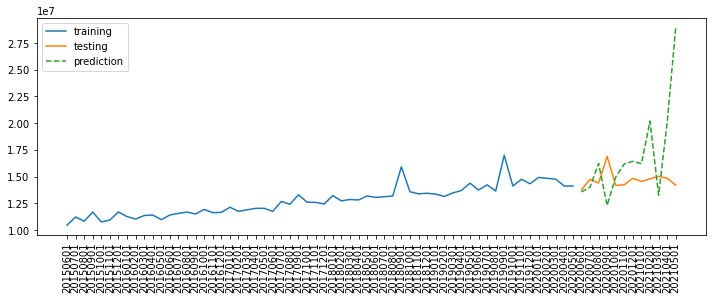

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Mean absolute error:  3370358.410676057


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.0s finished


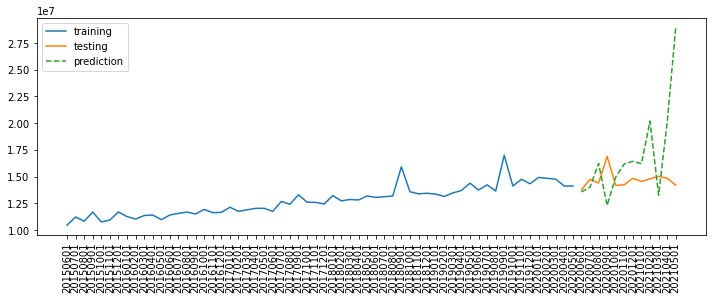

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Mean absolute error:  3358784.0300933695


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.0s finished


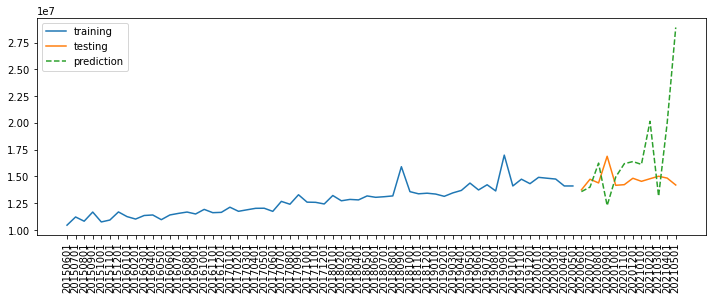

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Mean absolute error:  3355936.695747403


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.0s finished


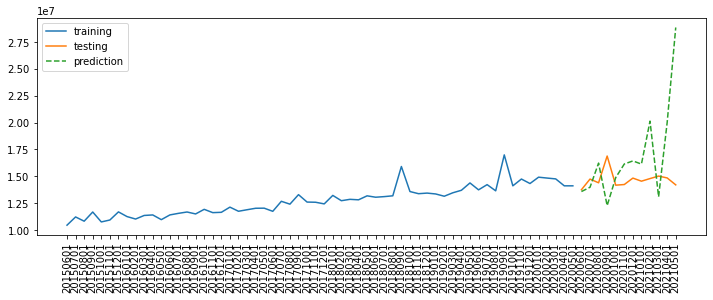

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Mean absolute error:  3558001.15387727


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.0s finished
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11220105028.821093, tolerance: 11108016109.185097
  model = cd_fast.enet_coordinate_descent(


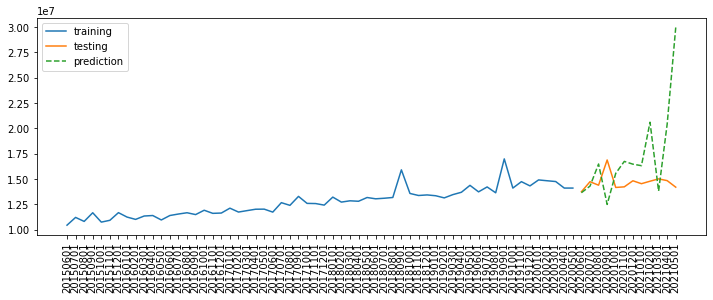

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Mean absolute error:  3600009.1223472483


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.0s finished
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12783308469.704773, tolerance: 11108016109.185097
  model = cd_fast.enet_coordinate_descent(


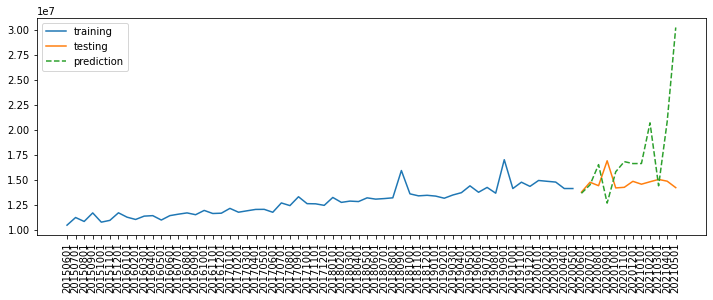

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Mean absolute error:  3695939.1081298795


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.0s finished
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13878766180.275215, tolerance: 11108016109.185097
  model = cd_fast.enet_coordinate_descent(


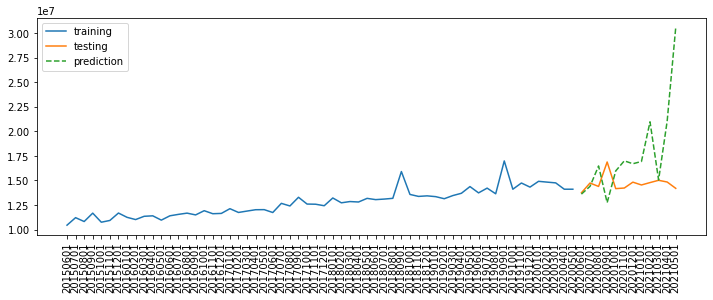

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Mean absolute error:  3591427.158065582


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.0s finished
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26798619587.281544, tolerance: 11108016109.185097
  model = cd_fast.enet_coordinate_descent(


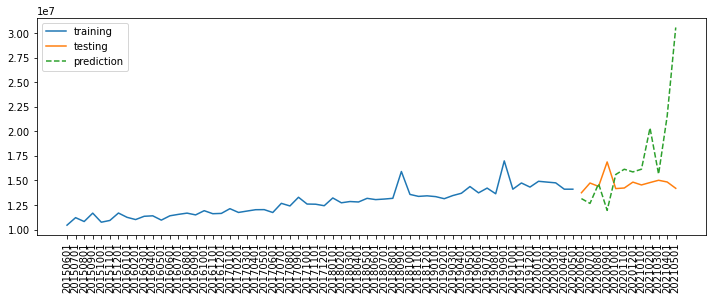

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Mean absolute error:  4332802.717872837


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.0s finished
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27019021494.423264, tolerance: 11108016109.185097
  model = cd_fast.enet_coordinate_descent(


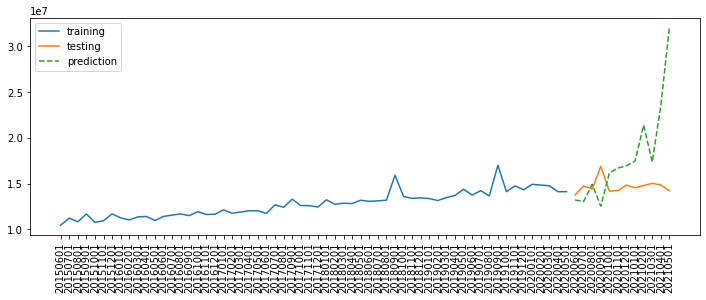

In [74]:
n_iter = 20
X_train_it = X_train.copy()
X_test_it = X_test.copy()
var_droped = []
mae_it = [y_train.abs().sum(),y_train.abs().sum()]
while mae_it[-1]*0.9 <= mae_it[-2]:
#for i in range(n_iter):
    best_model = gs_lasso
    gs_lasso = GridSearchCV(pipe, param_grid, n_jobs=-1, verbose=1, cv=tscv)
    gs_lasso.fit(X_train_it, y_train)
    coef = pd.DataFrame(gs_lasso.best_estimator_.named_steps["model"].coef_,
                        index = X_train_it.columns,
                        columns=['coefficient'])
    v = coef.abs().sort_values(['coefficient']).index[0]

    y_pred_gslasso = gs_lasso.predict(X_test_it)

    mae = mean_absolute_error(y_test, y_pred_gslasso)
    print("Mean absolute error: ", mae)
    mae_it.append(mae)

    fig, ax = plt.subplots(figsize=(12,4))

    ax.plot(y_train, label='training')
    ax.plot(y_test, label='testing')
    ax.plot(pd.DataFrame(y_pred_gslasso).set_index(y_test.index), label='prediction', ls="--")
    # Define the date format
    plt.xticks(rotation = 90)
    plt.legend()
    plt.show()

    X_train_it = X_train_it.drop(v, axis=1)
    X_test_it = X_test_it.drop(v, axis=1)
    var_droped.append(v)

In [75]:
var_droped

['401(K) PLANS5600 401K ADMINISTRATIONBasis Pts - Calc - RW',
 '401(K) PLANS5600 401K ADMINISTRATIONEnding Client Base - RW',
 'month_07',
 '401(K) PLANS5745 EPLANLoss % of BCB',
 'PRD351ASO5600 401K ADMINISTRATIONSales - RW',
 'GASREGW',
 '401(K) PLANS5745 EPLANBasis Pts - Calc - RW',
 't-12',
 '401(K) PLANS5020 EPlan SalesSales - RW']

In [76]:
len(var_droped)

9

<BarContainer object of 9 artists>

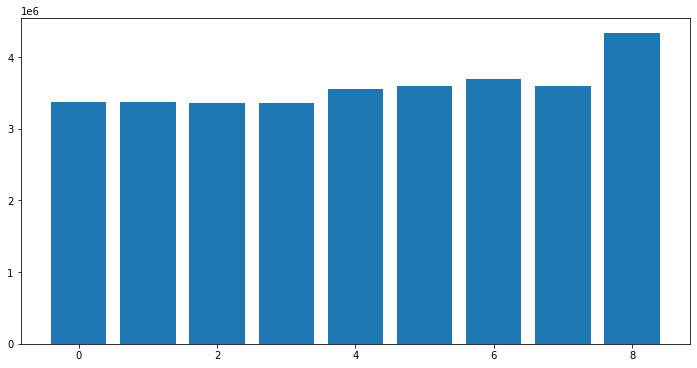

In [77]:
fig, ax = plt.subplots(figsize=(12,6))

ax.bar(np.arange(len(mae_it[2:])), mae_it[2:])

In [78]:
y_pred_gslasso = best_model.predict(X_test.drop(var_droped[:-2], axis=1))

mae = mean_absolute_error(y_test, y_pred_gslasso)
print("Mean absolute error: ", mae)

Mean absolute error:  3591427.158065582


In [79]:
coef.sort_values(['coefficient'], ascending=False)

,coefficient
401(K) PLANS5600 401K ADMINISTRATIONAverage Assets/Clients - Calculated - RW,1.054722e+07
401(K) PLANS5600 401K ADMINISTRATIONAverage Asset Values - Calculated - RW,9.779521e+06
FYFR,9.070823e+06
CIVPART,6.738409e+06
MORTGAGE15US,5.250641e+06
...,...
IRA SIMPLE5600 401K ADMINISTRATIONEnding Client Base - RW,-5.061070e+06
PRD351RRS5600 401K ADMINISTRATIONLoss % of BCB,-5.372489e+06
month_06,-7.648680e+06
401(K) PLANS5600 401K ADMINISTRATIONEnding Asset Values - RW,-9.429858e+06


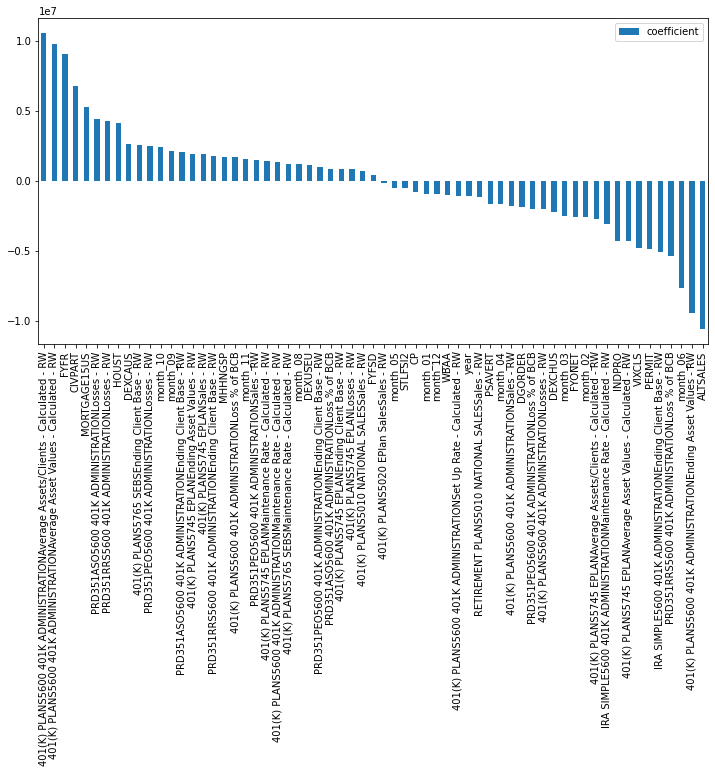

In [80]:
coef.sort_values(['coefficient'], ascending=False).plot.bar(figsize=(12,6))

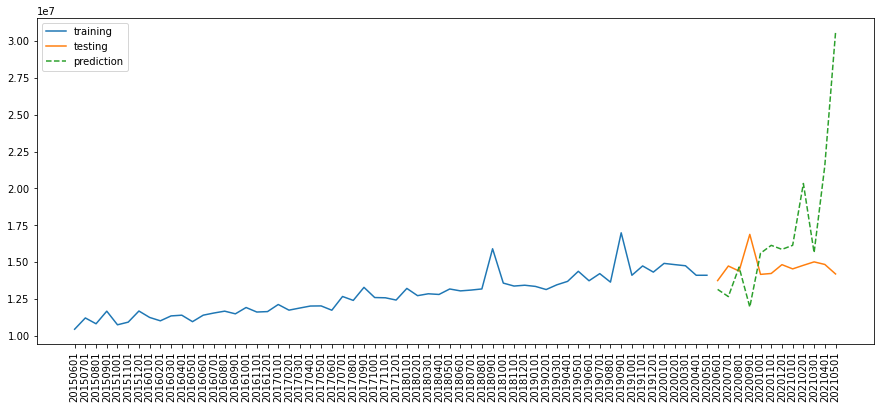

In [83]:
fig, ax = plt.subplots(figsize=(15,6))

# y_train.plot(ax=ax)
# y_test.plot(ax=ax)
ax.plot(y_train, label='training')
ax.plot(y_test, label='testing')
ax.plot(pd.DataFrame(y_pred_gslasso).set_index(y_test.index), label='prediction', ls="--")
# Define the date format
plt.xticks(rotation = 90)
plt.legend()

## Gradient boosting

In [142]:
from sklearn.ensemble import GradientBoostingRegressor

In [143]:
tscv = TimeSeriesSplit(n_splits=4)
model_gb = GradientBoostingRegressor()

In [173]:
parameters = {'learning_rate':[0.1, 0.3, 0.5],
              'n_estimators': [100, 150, 200],
              'max_depth': [3, 4, 5]}

In [174]:
for train_index, test_index in tscv.split(X_train):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11] TEST: [12 13 14 15 16 17 18 19 20 21 22 23]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [24 25 26 27 28 29 30 31 32 33 34 35]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35] TEST: [36 37 38 39 40 41 42 43 44 45 46 47]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [48 49 50 51 52 53 54 55 56 57 58 59]


Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  93 out of 108 | elapsed:    1.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    2.1s finished


Mean absolute error:  532207.2390834988
Mean absolute percentage error:  3.52


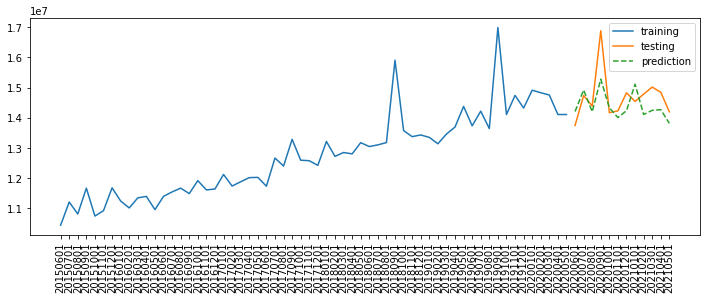

Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    2.2s finished


Mean absolute error:  521745.6191686459
Mean absolute percentage error:  3.44


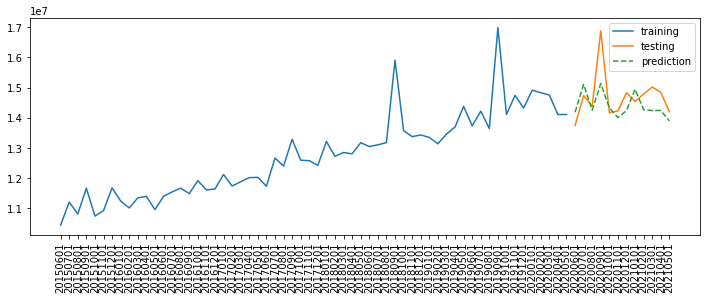

Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  93 out of 108 | elapsed:    1.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    2.0s finished


Mean absolute error:  512103.3734350906
Mean absolute percentage error:  3.4


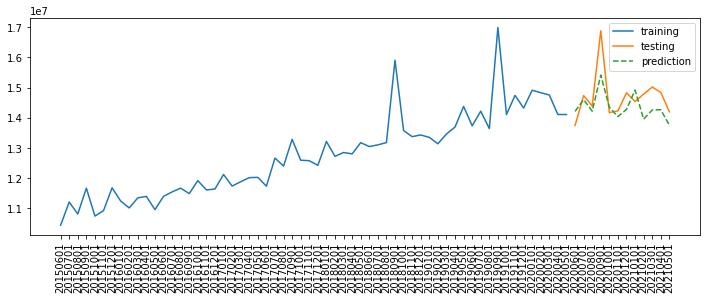

Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  93 out of 108 | elapsed:    1.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    2.0s finished


Mean absolute error:  784870.3351951152
Mean absolute percentage error:  5.17


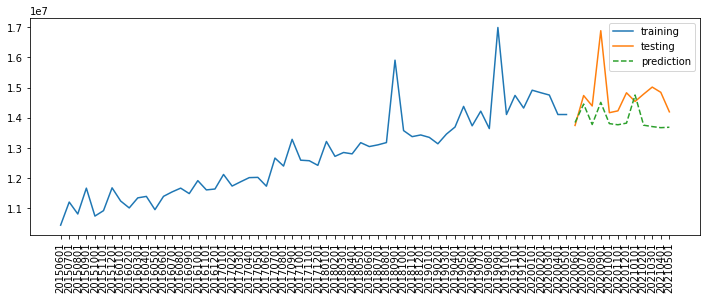

In [175]:
n_iter = 20
X_train_it = X_train.copy()
X_test_it = X_test.copy()
var_droped = []
mae_it = [y_train.abs().sum(),y_train.abs().sum()]
gs_gb = model_gb
while mae_it[-1]*0.85 <= mae_it[-2]:
#for i in range(n_iter):
    best_model = gs_gb
    gs_gb = GridSearchCV(model_gb, parameters, n_jobs=-1, verbose=1, cv=tscv)
    gs_gb.fit(X_train_it, y_train)
    coef = pd.DataFrame(gs_gb.best_estimator_.feature_importances_,
                        index = X_train_it.columns,
                        columns=['coefficient'])
    v = coef.abs().sort_values(['coefficient']).index[0]

    y_pred_gsgb = gs_gb.predict(X_test_it)

    mae = mean_absolute_error(y_test, y_pred_gsgb)
    mape = mean_absolute_percentage_error(y_test, y_pred_gsgb)
    print("Mean absolute error: ", mae)
    print("Mean absolute percentage error: ", round(mape*100,2))
    mae_it.append(mae)

    fig, ax = plt.subplots(figsize=(12,4))

    ax.plot(y_train, label='training')
    ax.plot(y_test, label='testing')
    ax.plot(pd.DataFrame(y_pred_gsgb).set_index(y_test.index), label='prediction', ls="--")
    # Define the date format
    plt.xticks(rotation = 90)
    plt.legend()
    plt.show()

    X_train_it = X_train_it.drop(v, axis=1)
    X_test_it = X_test_it.drop(v, axis=1)
    var_droped.append(v)

In [176]:
var_droped

['month_10',
 'month_01',
 '401(K) PLANS5600 401K ADMINISTRATIONBasis Pts - Calc - RW',
 'month_08']

<BarContainer object of 4 artists>

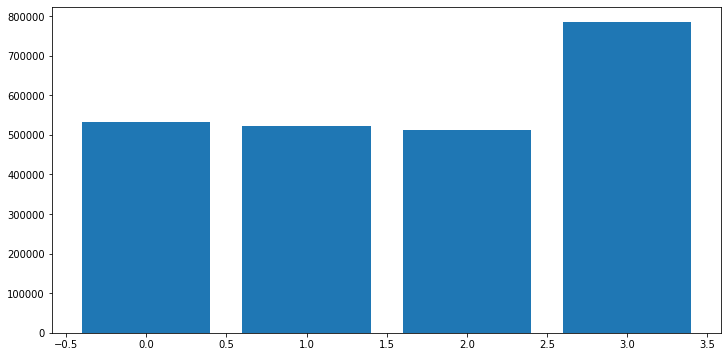

In [177]:
fig, ax = plt.subplots(figsize=(12,6))

ax.bar(np.arange(len(mae_it[2:])), mae_it[2:])

In [178]:
best_model.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.3, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [179]:
best_model.best_params_

{'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 150}

In [180]:
y_pred = best_model.predict(X_test.drop(var_droped[:-2], axis=1))

In [181]:
mae = mean_absolute_error(y_test, y_pred)
print("Mean absolute error: ", mae)

Mean absolute error:  512103.3734350906


In [183]:
mape = mean_absolute_percentage_error(y_test, y_pred)
print("Mean absolute error: ", mape*100)

Mean absolute error:  3.397232611344853


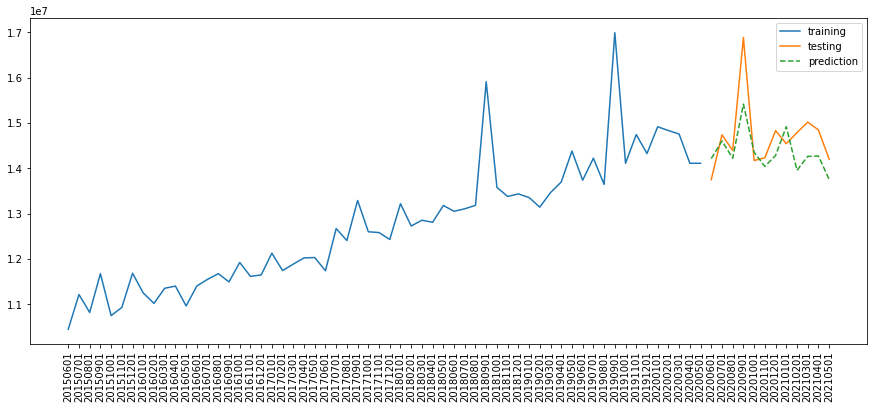

In [184]:
fig, ax = plt.subplots(figsize=(15,6))

# y_train.plot(ax=ax)
# y_test.plot(ax=ax)
ax.plot(y_train, label='training')
ax.plot(y_test, label='testing')
ax.plot(pd.DataFrame(y_pred).set_index(y_test.index), label='prediction', ls="--")
# Define the date format
plt.xticks(rotation = 90)
plt.legend()

## Function

### 401K Fee Revenue

In [384]:
model = GradientBoostingRegressor(random_state=1)

In [385]:
item_name = '401K Fee Revenue'
driver_name = '401kRevenue Drivers'
parameters = {'learning_rate':[0.1, 0.3, 0.5],
              'n_estimators': [100, 150, 200],
              'max_depth': [3, 4, 5]}

In [386]:
 X, y = create_X(item_name, df, df_external, driver_name, df_drivers, ohe_months=True)

Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    3.6s finished


Mean absolute error:  560910.7865983987
Mean absolute percentage error:  3.68


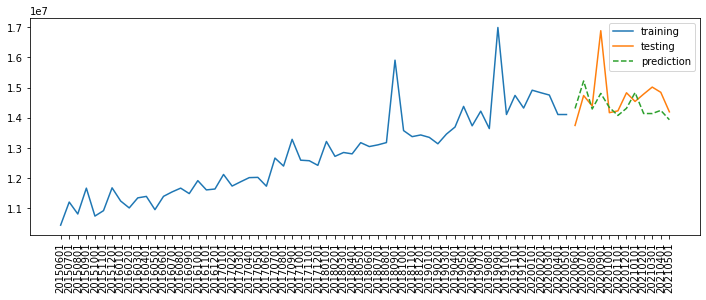

Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  93 out of 108 | elapsed:    1.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    2.0s finished


Mean absolute error:  517143.38168219134
Mean absolute percentage error:  3.39


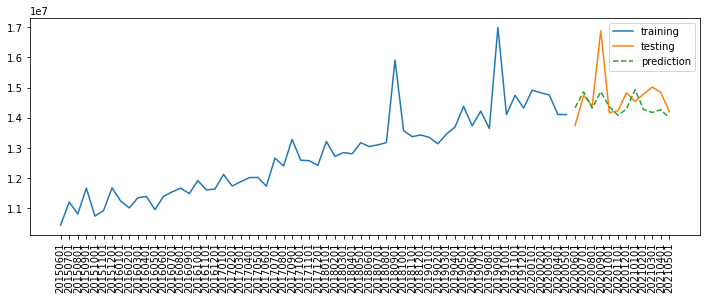

Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    2.0s finished


Mean absolute error:  652545.2845632844
Mean absolute percentage error:  4.3


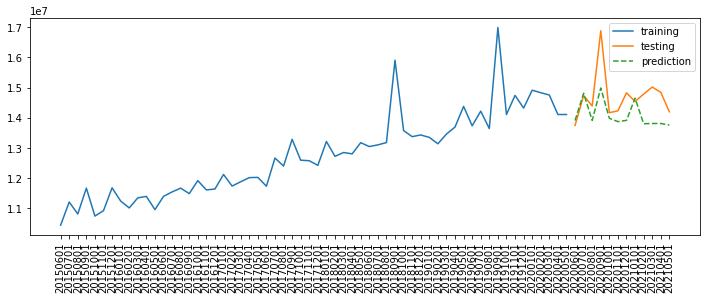

In [387]:
model, var_droped, mape =model_train_featue_selection(model, X, y)

In [388]:
var_droped

['month_12', '401(K) PLANS5600 401K ADMINISTRATIONBasis Pts - Calc - RW']

<BarContainer object of 3 artists>

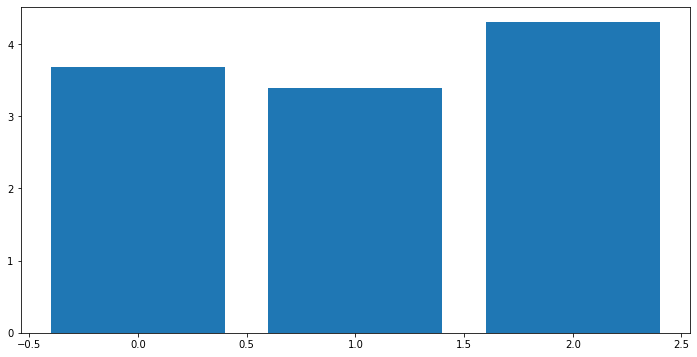

In [389]:
fig, ax = plt.subplots(figsize=(12,6))

ax.bar(np.arange(len(mape)), np.array(mape)*100)

In [390]:
model.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}

In [391]:
mape[-2]*100

3.3894777423100995

In [392]:
pd.DataFrame(model.best_estimator_.feature_importances_,
             index = X.drop(var_droped[:-1], axis=1).columns,
             columns = ["Feature importance"]) \
.sort_values(["Feature importance"], ascending=False)

,Feature importance
IRA SIMPLE5600 401K ADMINISTRATIONMaintenance Rate - Calculated - RW,5.871654e-01
401(K) PLANS5745 EPLANMaintenance Rate - Calculated - RW,8.881564e-02
PRD351RRS5600 401K ADMINISTRATIONEnding Client Base - RW,5.827653e-02
DEXUSEU,5.695753e-02
401(K) PLANS5600 401K ADMINISTRATIONEnding Client Base - RW,5.334797e-02
...,...
401(K) PLANS5745 EPLANLoss % of BCB,1.333396e-10
month_07,0.000000e+00
month_04,0.000000e+00
401(K) PLANS5600 401K ADMINISTRATIONBasis Pts - Calc - RW,0.000000e+00


### 401K Asset fee & BP Revenue

In [408]:
item_name = '401K Asset fee & BP Revenue'
driver_name = '401kRevenue Drivers'
model = GradientBoostingRegressor()
parameters = {'learning_rate':[0.1, 0.3, 0.5],
              'n_estimators': [100, 150, 200],
              'max_depth': [3, 4, 5]}

In [409]:
 X, y = create_X(item_name, df, df_external, driver_name, df_drivers, ohe_months=False)

Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  93 out of 108 | elapsed:    1.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.9s finished


Mean absolute error:  985874.493420451
Mean absolute percentage error:  11.35


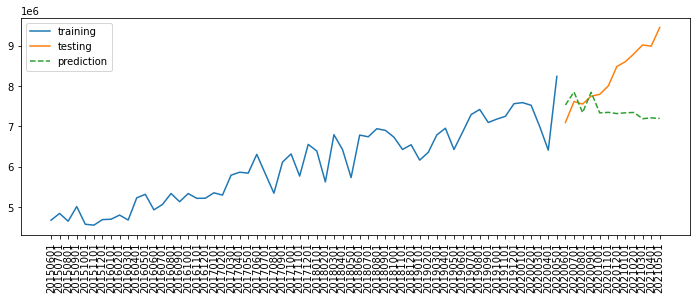

Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  93 out of 108 | elapsed:    1.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.9s finished


Mean absolute error:  812668.1132212911
Mean absolute percentage error:  9.35


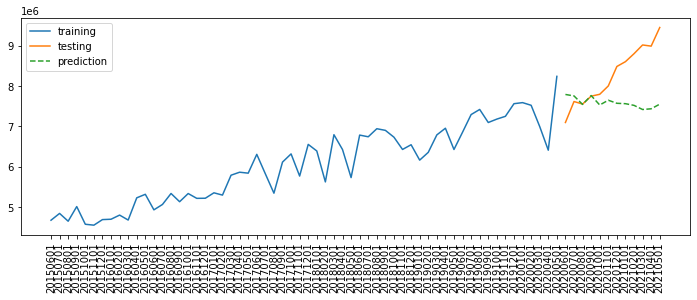

Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  93 out of 108 | elapsed:    1.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.9s finished


Mean absolute error:  1053405.8177280652
Mean absolute percentage error:  12.22


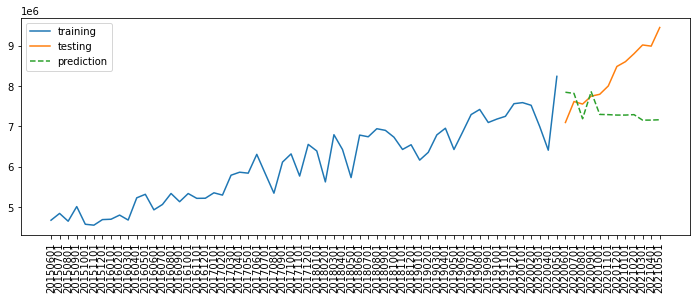

In [410]:
model, var_droped, mape =model_train_featue_selection(model=model, X=X, y=y)

In [411]:
model.best_params_

{'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 200}

In [412]:
var_droped

['401(K) PLANS5600 401K ADMINISTRATIONBasis Pts - Calc - RW',
 '401(K) PLANS5600 401K ADMINISTRATIONLoss % of BCB']

<BarContainer object of 5 artists>

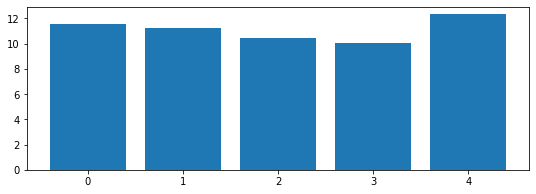

In [413]:
fig, ax = plt.subplots(figsize=(9,3))

ax.bar(np.arange(len(mae)), np.array(mae)*100)

In [414]:
print("MAPE without months: ", mape[-2]*100)

MAPE without months:  9.347865643376851


In [415]:
pd.DataFrame(model.best_estimator_.feature_importances_,
             index = X.drop(var_droped[:-1], axis=1).columns,
             columns = ["Feature importance"]) \
.sort_values(["Feature importance"], ascending=False)

,Feature importance
401(K) PLANS5600 401K ADMINISTRATIONEnding Client Base - RW,7.113471e-01
401(K) PLANS5600 401K ADMINISTRATIONEnding Asset Values - RW,5.594089e-02
FYONET,4.235933e-02
CP,2.920887e-02
401(K) PLANS5745 EPLANAverage Asset Values - Calculated - RW,2.746812e-02
FYFSD,2.616789e-02
PRD351PEO5600 401K ADMINISTRATIONLosses - RW,1.916390e-02
MHHNGSP,1.190909e-02
401(K) PLANS5745 EPLANEnding Client Base - RW,1.051841e-02
401(K) PLANS5745 EPLANEnding Asset Values - RW,1.022442e-02


### Workers Comp - Payment Services

In [416]:
item_name = 'Workers Comp - Payment Services'
driver_name = 'Workers Comp - Payment Services Drivers'
model = GradientBoostingRegressor()
parameters = {'learning_rate':[0.1, 0.3, 0.5],
              'n_estimators': [100, 150, 200],
              'max_depth': [3, 4, 5]}

In [417]:
 X, y = create_X(item_name, df, df_external, driver_name, df_drivers, ohe_months=False)

Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  93 out of 108 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.7s finished


Mean absolute error:  2190787.4493565536
Mean absolute percentage error:  36.38


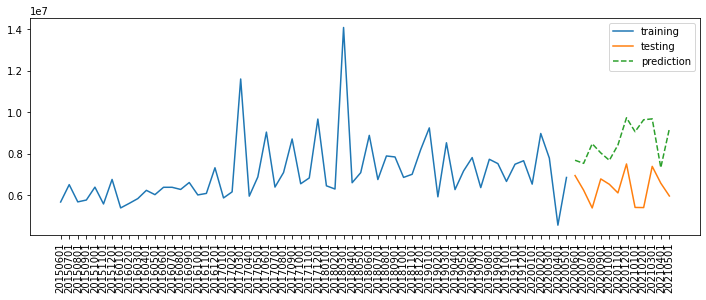

Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.7s finished


Mean absolute error:  2364546.0661752163
Mean absolute percentage error:  39.1


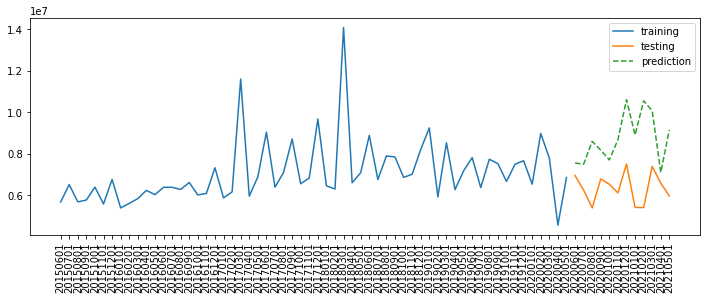

Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  93 out of 108 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.6s finished


Mean absolute error:  2250656.851839093
Mean absolute percentage error:  37.34


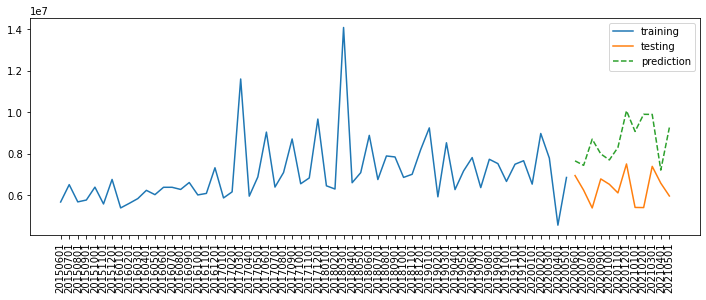

Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  93 out of 108 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.6s finished


Mean absolute error:  2128373.2413833872
Mean absolute percentage error:  35.47


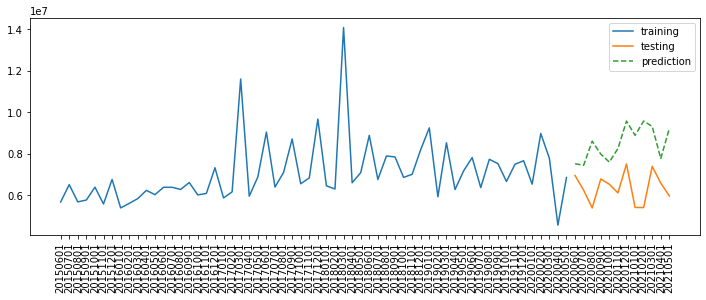

Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  93 out of 108 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.6s finished


Mean absolute error:  2284340.538892544
Mean absolute percentage error:  37.99


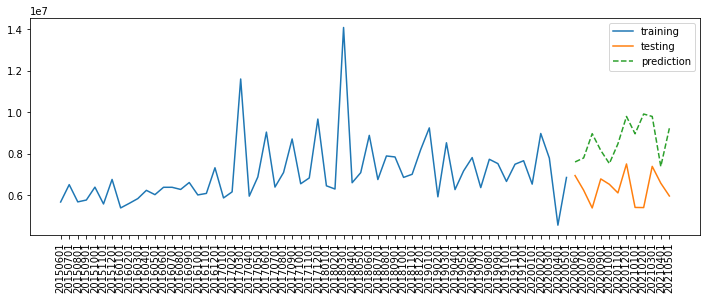

Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  93 out of 108 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.6s finished


Mean absolute error:  2094270.7994932625
Mean absolute percentage error:  34.89


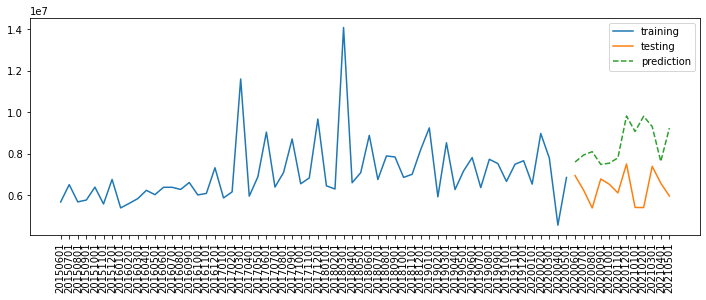

Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  93 out of 108 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.6s finished


Mean absolute error:  2159940.2503034305
Mean absolute percentage error:  35.88


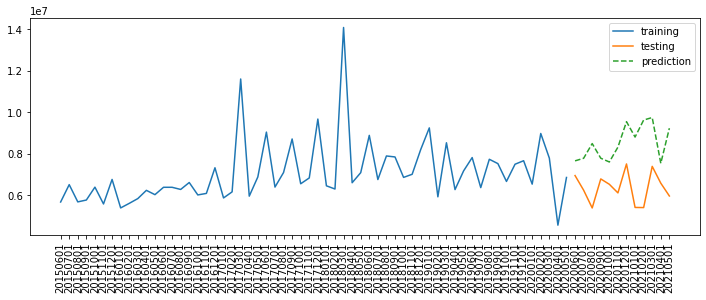

Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  93 out of 108 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.6s finished


Mean absolute error:  2150246.9229056956
Mean absolute percentage error:  35.81


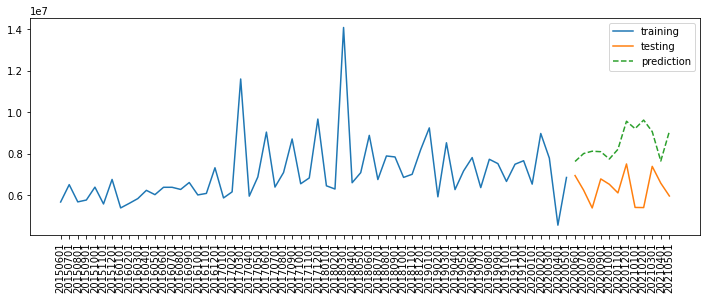

Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  93 out of 108 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.5s finished


Mean absolute error:  1700576.5182714376
Mean absolute percentage error:  28.46


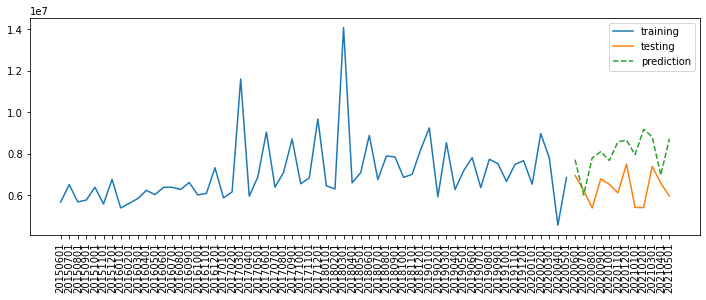

Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  93 out of 108 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.6s finished


Mean absolute error:  2271199.820321819
Mean absolute percentage error:  37.75


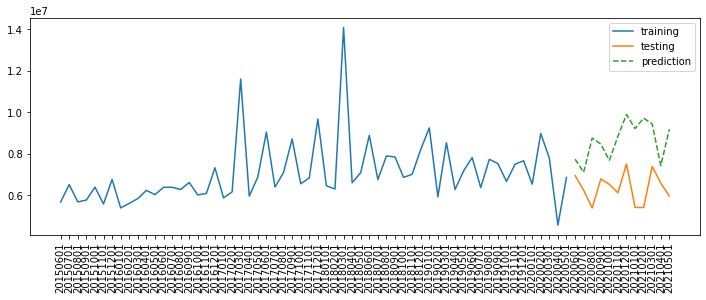

In [418]:
model, var_droped, mape =model_train_featue_selection(model=model, X=X, y=y)

In [419]:
print("MAPE without months: ", mape[-2]*100)

MAPE without months:  28.46097374314887


In [421]:
model.best_params_

{'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 100}

In [420]:
pd.DataFrame(model.best_estimator_.feature_importances_,
             index = X.drop(var_droped[:-1], axis=1).columns,
             columns = ["Feature importance"]) \
.sort_values(["Feature importance"], ascending=False)

,Feature importance
t-12,0.322533
FYFR,0.147042
ALTSALES,0.089610
WC DIRECT BILL5310 AGENCY REPORTING AND PROJECT MANAGEMENTSales - RW,0.061324
FYFSD,0.057176
MHHNGSP,0.049914
WORK COMP5310 AGENCY REPORTING AND PROJECT MANAGEMENTEnding Client Base - RW,0.049781
DEXCHUS,0.040787
STLFSI2,0.031936
WORK COMP5310 AGENCY REPORTING AND PROJECT MANAGEMENTSales - RW,0.021755


### 'Health Benefits'

In [359]:
item_name = 'Health Benefits'
driver_name = 'Health Benefits Drivers'
model = GradientBoostingRegressor()
parameters = {'learning_rate':[0.1, 0.3, 0.5],
              'n_estimators': [100, 150, 200],
              'max_depth': [3, 4, 5]}

In [360]:
 X, y = create_X(item_name, df, df_external, driver_name, df_drivers, ohe_months=False)

Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    3.3s finished


Mean absolute error:  968889.3671724005
Mean absolute percentage error:  10.47


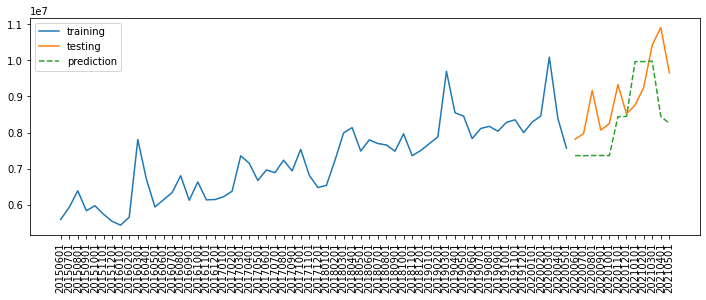

Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  93 out of 108 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.6s finished


Mean absolute error:  794441.4428410409
Mean absolute percentage error:  8.23


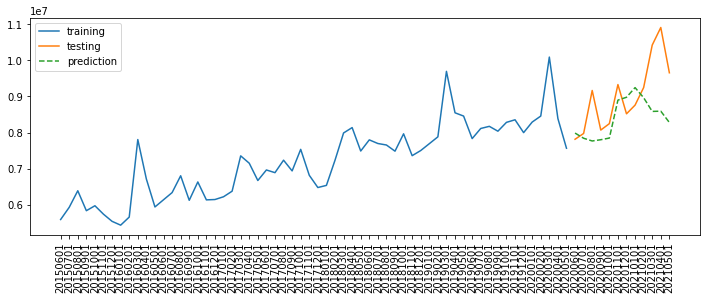

Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  93 out of 108 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.6s finished


Mean absolute error:  724820.8996824054
Mean absolute percentage error:  7.55


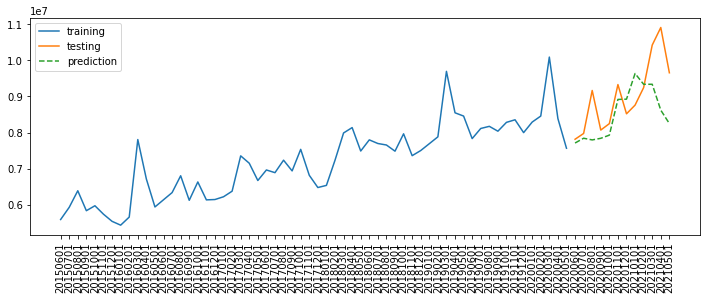

Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  93 out of 108 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.6s finished


Mean absolute error:  677325.9293932457
Mean absolute percentage error:  7.06


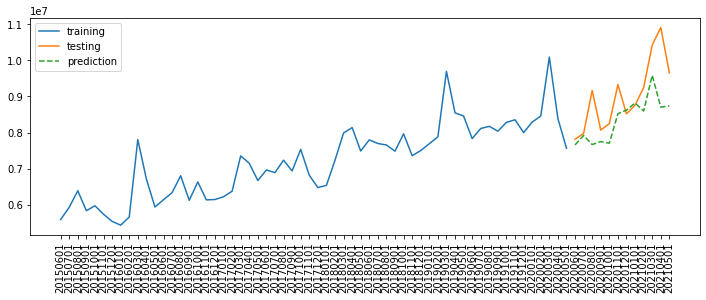

Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.6s finished


Mean absolute error:  1014317.3948506704
Mean absolute percentage error:  11.0


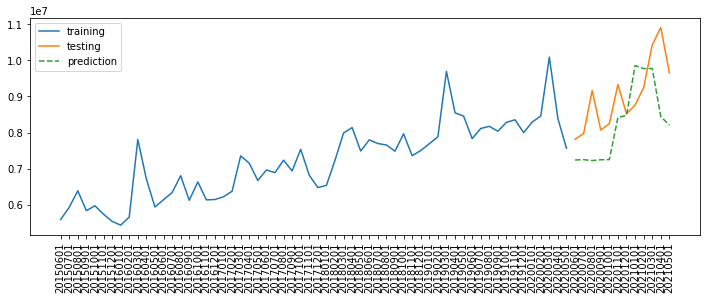

In [361]:
model, var_droped, mape =model_train_featue_selection(model=model, X=X, y=y)

In [362]:
print("MAPE without months: ", mape[-2]*100)

MAPE without months:  7.056884084641559


In [370]:
pd.DataFrame(model.best_estimator_.feature_importances_,
             index = X.drop(var_droped[:-1], axis=1).columns,
             columns = ["Feature importance"]) \
.sort_values(["Feature importance"], ascending=False)

,Feature importance
t-12,7.883793e-01
OTHER H&B REVENUE5310 AGENCY REPORTING AND PROJECT MANAGEMENTEnding Worksite Employee Base - RW,8.498801e-02
OTHER H&B REVENUE5310 AGENCY REPORTING AND PROJECT MANAGEMENTEnding Client Base - RW,3.817292e-02
WBAA,2.364689e-02
DGORDER,1.803926e-02
PERMIT,9.269056e-03
ALTSALES,8.225865e-03
OTHER H&B REVENUE5310 AGENCY REPORTING AND PROJECT MANAGEMENTLosses - RW,7.337181e-03
STLFSI2,4.539788e-03
VIXCLS,3.915648e-03


### 'HR Online'

In [422]:
item_name = 'HR Online'
driver_name = 'Online Revenue Drivers'
model = GradientBoostingRegressor()
parameters = {'learning_rate':[0.1, 0.3, 0.5],
              'n_estimators': [100, 150, 200],
              'max_depth': [3, 4, 5]}

In [423]:
 X, y = create_X(item_name, df, df_external, driver_name, df_drivers, ohe_months=False)

Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  93 out of 108 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.7s finished


Mean absolute error:  160970.12328518965
Mean absolute percentage error:  3.9


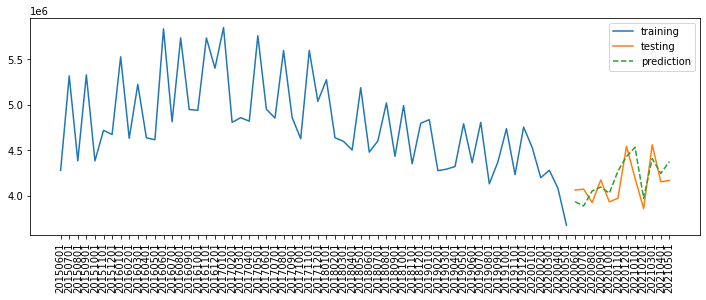

Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  93 out of 108 | elapsed:    1.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.8s finished


Mean absolute error:  198399.35577023434
Mean absolute percentage error:  4.84


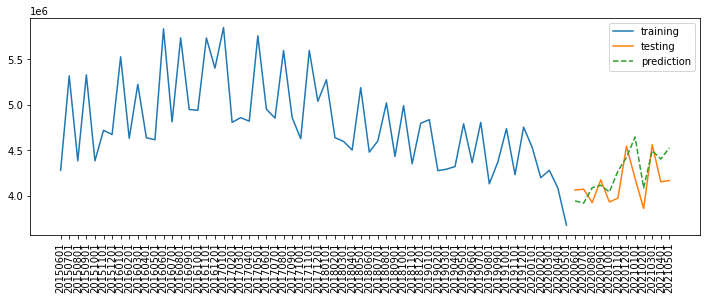

In [424]:
model, var_droped, mape =model_train_featue_selection(model=model, X=X, y=y)

In [428]:
print("MAPE: ", mape[-2]*100)

MAPE:  3.90398424020142


In [425]:
model.best_params_

{'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 200}

In [426]:
pd.DataFrame(model.best_estimator_.feature_importances_,
             index = X.drop(var_droped[:-1], axis=1).columns,
             columns = ["Feature importance"]) \
.sort_values(["Feature importance"], ascending=False)

,Feature importance
SMART TIME 3695505 SMART TIMESales - RW,5.807530e-01
PSAVERT,8.510662e-02
DEXCHUS,6.446704e-02
ALTSALES,6.367243e-02
TLO5000 TIME AND ATTENDANCEDiscount % - RW,6.015458e-02
DGORDER,2.297992e-02
DEXCAUS,1.672622e-02
EAO5500 HR ONLINE SERVICESDiscount % - RW,1.528080e-02
EAO5500 HR ONLINE SERVICESEnding Client Base - RW,1.481610e-02
t-12,1.030184e-02
